In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, mnist_transform
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

In [2]:
train_loader, valid_loader, test_loader = mnist(valid=10000)

train_length = 200
train_data = datasets.MNIST('./MNIST_data', train=True, download=True, transform=mnist_transform)
train_loader = DataLoader(train_data, batch_size=50, sampler=SubsetRandomSampler( np.arange(train_length) ))

In [3]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 10)
        if batchnorm:
            self.bn = nn.BatchNorm1d(128)
        self.batchnorm = batchnorm
        
        self.dropout = dropout
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.tanh(self.fc1(x))
        if self.batchnorm:
            x = self.bn(x)
        x = torch.tanh(self.fc2(x))
        if self.dropout:
            x = F.dropout(x, 0.5)
        x = self.fc3(x)
        x = torch.log_softmax(x, dim=1)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [4]:
def train(epoch, models):
    train_size = len(train_loader.sampler)
        
    for batch_idx, (data, target) in enumerate(train_loader):
        for k, model in models.items():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        print(line + losses)

In [5]:
def test(models, loader, log=None):
    test_size = len(loader.sampler)
    
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    
    with torch.no_grad():
        for data, target in loader:
            # output = {k: m(data) for m in models}
            for k, m in models.items():
                output = m(data)
                test_loss[k] += m.loss(output, target, reduction='sum').item() # sum up batch loss
                pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: 100. * correct[k] / test_size for k in correct}
    lines = '\n'.join([line(k, test_loss[k], correct[k], correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [6]:
def plot_train_test(train_log, test_log):
    data = {}
    for name, model in train_log.items():
        train_name = '{}_train'.format(name)
        test_name = '{}_test'.format(name)
        data[train_name] = model
        data[test_name] = test_log[name]
    
    plot_graphs(data, 'loss')
    plot_graphs(data, 'accuracy')

In [32]:
#models = {'default': Net(False, False), 'bn': Net(True, False), 'drop': Net(False, True), 'both': Net(True, True)}
models = {'both_rescaled': Net(True, True, lr=1e-2)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [33]:
%%time
'''
for model in models.values():
    for g in model.optim.param_groups:
        g['lr'] = 1e-3
'''

for epoch in range(0, 50):
    for model in models.values():
        model.train()
    train(epoch, models)
    for model in models.values():
        model.eval()
    test(models, train_loader, train_log)
    test(models, test_loader, test_log)

Train Epoch: 0 [0/200 (0%)]	Losses both_rescaled: 2.374584
Train Epoch: 0 [200/200 (100%)]	Losses both_rescaled: 1.379354
epoch 0
Test set:
both_rescaled: Loss: 1.0582	Accuracy: 165.0/200 (82%)

Test set:
both_rescaled: Loss: 1.4269	Accuracy: 5651.0/10000 (57%)

Train Epoch: 1 [0/200 (0%)]	Losses both_rescaled: 0.854695
Train Epoch: 1 [200/200 (100%)]	Losses both_rescaled: 0.561140
epoch 1
Test set:
both_rescaled: Loss: 0.4399	Accuracy: 183.0/200 (92%)

Test set:
both_rescaled: Loss: 1.0772	Accuracy: 6449.0/10000 (64%)

Train Epoch: 2 [0/200 (0%)]	Losses both_rescaled: 0.283607
Train Epoch: 2 [200/200 (100%)]	Losses both_rescaled: 0.256556
epoch 2
Test set:
both_rescaled: Loss: 0.2498	Accuracy: 191.0/200 (96%)

Test set:
both_rescaled: Loss: 0.9747	Accuracy: 7019.0/10000 (70%)

Train Epoch: 3 [0/200 (0%)]	Losses both_rescaled: 0.292150
Train Epoch: 3 [200/200 (100%)]	Losses both_rescaled: 0.127104
epoch 3
Test set:
both_rescaled: Loss: 0.0965	Accuracy: 195.0/200 (98%)

Test set:
both_r


Train Epoch: 31 [0/200 (0%)]	Losses both_rescaled: 0.000628
Train Epoch: 31 [200/200 (100%)]	Losses both_rescaled: 0.000307
epoch 31
Test set:
both_rescaled: Loss: 0.0004	Accuracy: 200.0/200 (100%)

Test set:
both_rescaled: Loss: 1.3248	Accuracy: 7535.0/10000 (75%)

Train Epoch: 32 [0/200 (0%)]	Losses both_rescaled: 0.000579
Train Epoch: 32 [200/200 (100%)]	Losses both_rescaled: 0.000215
epoch 32
Test set:
both_rescaled: Loss: 0.0003	Accuracy: 200.0/200 (100%)

Test set:
both_rescaled: Loss: 1.3198	Accuracy: 7533.0/10000 (75%)

Train Epoch: 33 [0/200 (0%)]	Losses both_rescaled: 0.000266
Train Epoch: 33 [200/200 (100%)]	Losses both_rescaled: 0.000302
epoch 33
Test set:
both_rescaled: Loss: 0.0006	Accuracy: 200.0/200 (100%)

Test set:
both_rescaled: Loss: 1.3263	Accuracy: 7532.0/10000 (75%)

Train Epoch: 34 [0/200 (0%)]	Losses both_rescaled: 0.001004
Train Epoch: 34 [200/200 (100%)]	Losses both_rescaled: 0.000298
epoch 34
Test set:
both_rescaled: Loss: 0.0003	Accuracy: 200.0/200 (100%)


Train length=200


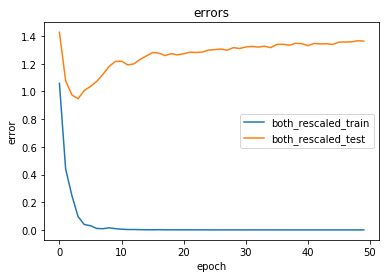

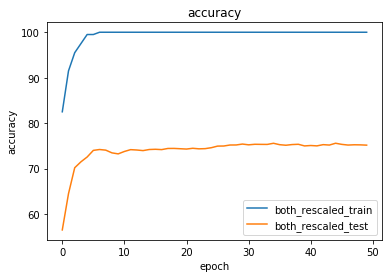

In [34]:
print('Train length=%d' % train_length)
plot_train_test(train_log, test_log)
# Net(False, True, lr=1e-3) N=200

In [30]:
for k in list(test_log.keys()):
    if k != 'both_rescaled':
        del test_log[k]

In [ ]:
train